# Assignment 1 – Practical Deep Learning Workshop
###Team OSO
We are going to show step by step process of trainning a conventional neural network on dog breed identification dataset, then we will use a pre-trained model and fit it to the data and analyze the results.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import RMSprop
import cv2
from tqdm import tqdm
from PIL import Image
import keras
from keras.preprocessing.image import load_img, img_to_array 
from keras.models import load_model
import PIL
import timeit

## Section 1 - Data analysis

We will start by extracting the zip files of the train data set, testing the data and adding jpg extension to the images in the labels file. Then we are displaying sample of the labeled data.

In [ ]:
def append_ext(fn):
    return fn+".jpg"

In [ ]:
labeldf= pd.read_csv('/content/sample_data/labels.csv',dtype=str)
train_zip_path = '/content/sample_data/train.zip'
test_zip_path = '/content/sample_data/test.zip'
sample_submission_zip_path = '/content/sample_data/sample_submission.csv.zip'
zip_ref = zipfile.ZipFile(train_zip_path, 'r')
zip_ref.extractall('/content/sample_data/train')
zip_ref = zipfile.ZipFile(test_zip_path, 'r')
zip_ref.extractall('/content/sample_data/test')
zip_ref = zipfile.ZipFile(sample_submission_zip_path, 'r')
zip_ref.extractall('/content/sample_data/')
labeldf["id"] = labeldf["id"].apply(append_ext) 

zip_ref.close()
validatedf = pd.read_csv('/content/sample_data/sample_submission.csv',dtype=str)
validatedf["id"] = validatedf["id"].apply(append_ext)
labeldf.sample(5)

id                   breed
9297   e9711a024b141baa00e640231bc461a9.jpg  welsh_springer_spaniel
10027  fb80f89c84c6c2649964b574918e02d6.jpg            newfoundland
2142   3568cac55c6785da3ae8ea575e46fc7d.jpg      bedlington_terrier
8256   ce92370c283c12eb64271cdec81fc1d5.jpg    old_english_sheepdog
3024   4acfbe200ca3a0f7530ec6387b73210b.jpg                  basset

Checking the number of images we have for trainning and testing the model and the number of classes the model needs to classify.

In [ ]:
labels_names=labeldf["breed"].unique()
num_images = len(labeldf["id"])
print('Number of images in Training file:', num_images)
list_test_images = os.listdir('/content/sample_data/test')
num_test_images = len(list_test_images)
print('Number of images in test directory:', num_test_images)
no_labels=len(labels_names)
print('Number of dog breeds in Training file:', no_labels)


Number of images in Training file: 10222
Number of images in test directory: 10357
Number of dog breeds in Training file: 120


Presenting histogram of the data per breed

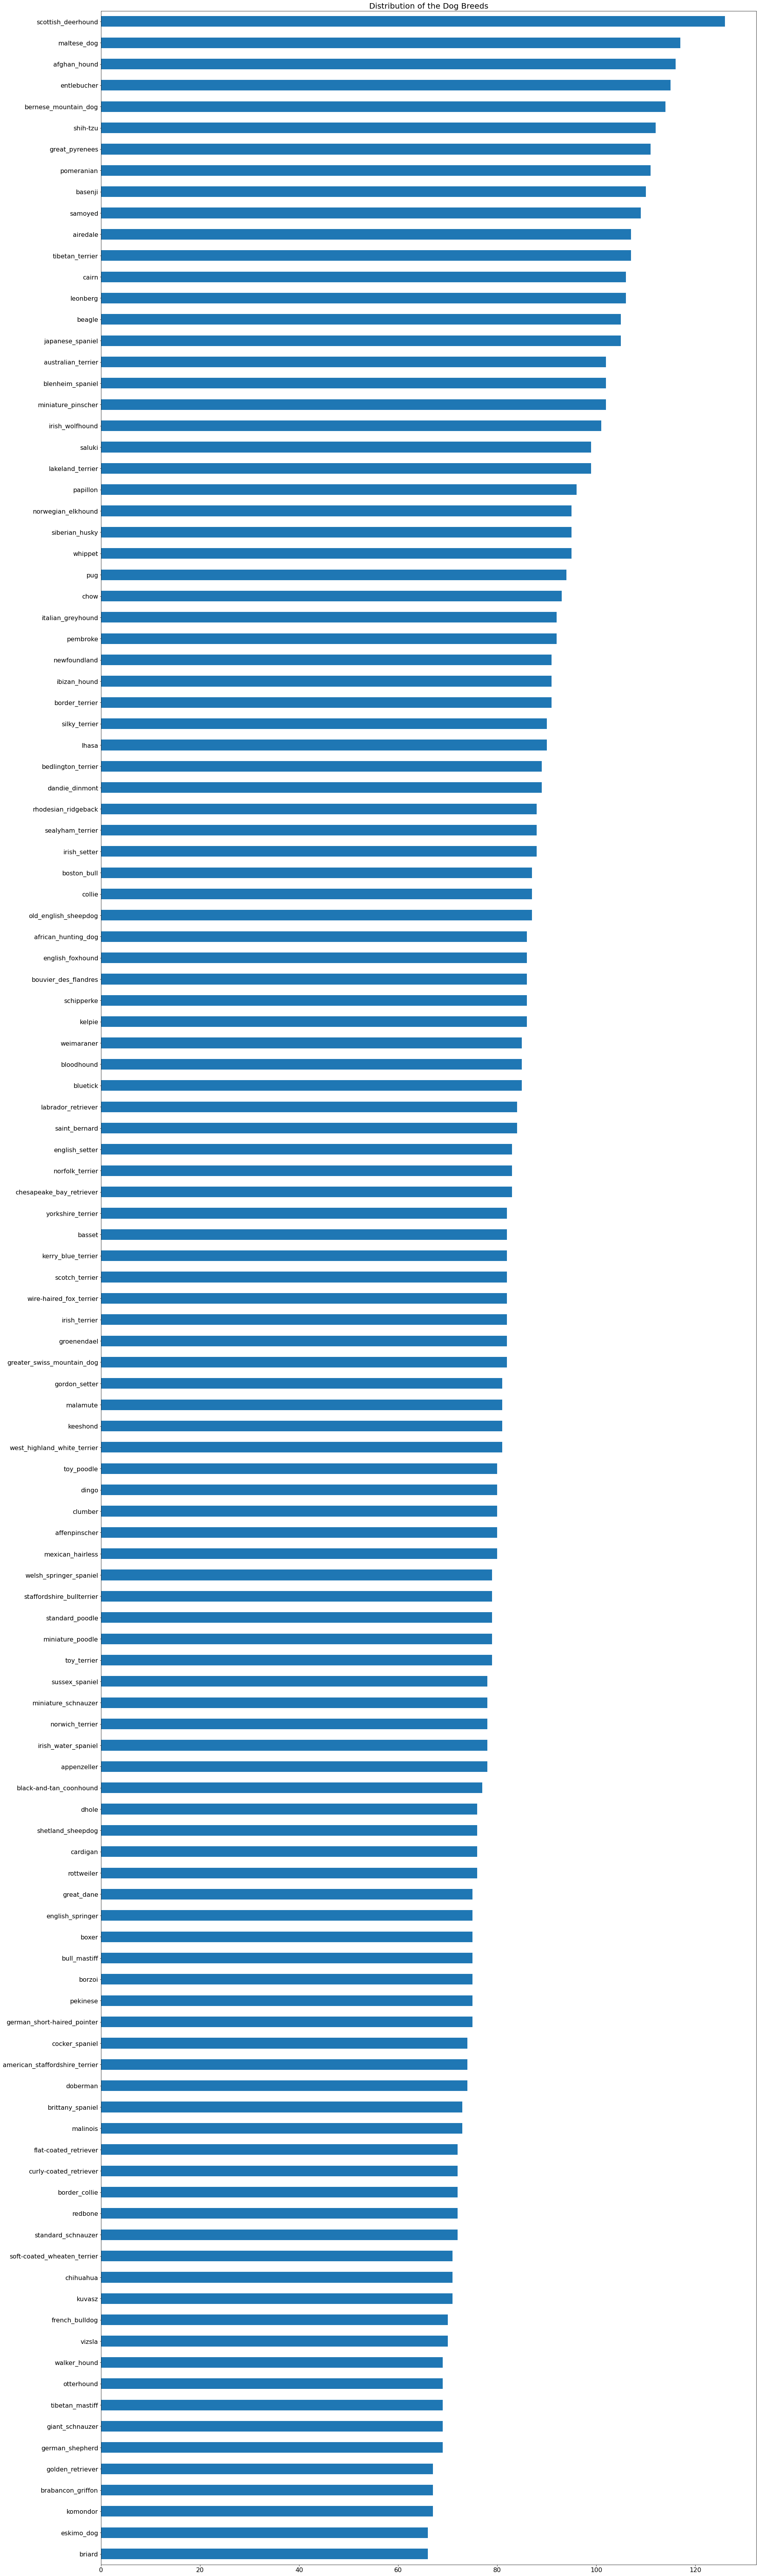

In [ ]:
bar = labeldf["breed"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the Dog Breeds", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

Let's check how many train images we have per breed

In [ ]:
gr_labels = labeldf.groupby("breed").count()
gr_labels = gr_labels.rename(columns = {"id" : "count"})
gr_labels = gr_labels.sort_values("count", ascending=False)
gr_labels

count
breed                      
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
...                     ...
golden_retriever         67
brabancon_griffon        67
komondor                 67
briard                   66
eskimo_dog               66

[120 rows x 1 columns]

We can see the distribution of the images per breed is not uniform, most popular breed in dataset is scottish deerhound with 126 images, and the least popular is eskimo dog with 66 images.

**Benchmarks** - These are the results for all popular models used in the same data set:
1.  VGGNet 19 : 
         Accuracy: 83%
         Log Loss: 0.56 

2. Inception V3: 
         Accuracy: 87%
         Log Loss: 0.47

3. ResNet50: 
         Accuracy: 90%
         Log Loss: 0.38

4. Xception: 
        Accuracy: 89%
        Log Loss: 0.42

5. DenseNet:
        Accuracy: 91%
        Log Loss: 0.36

6. SENet:
        Accuracy: 89%
        Log Loss: 0.38

7. ResNext:
        Accuracy: 93%
        Log Loss: 0.22

8. InceptionV4:
        Accuracy: 94%
        Log Loss: 0.20

9. InceptionResnetV2:
        Accuracy: 95%
        Log Loss: 0.19

10. Ensembling InceptionResNetV2, InceptionV4 and ResNext:
        Accuracy: 96%
        Log Loss: 0.16

Example of image from training set:

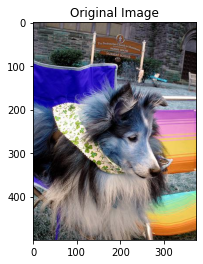

In [ ]:
img_1 = cv2.imread('/content/sample_data/train/004396df1acd0f1247b740ca2b14616e.jpg', cv2.IMREAD_UNCHANGED)
plt.title('Original Image')
plt.imshow(img_1)

In [ ]:
# get dimensions of image
dimensions = img_1.shape
 
# height, width, number of channels in image
height = img_1.shape[0]
width = img_1.shape[1]
channels = img_1.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (500, 375, 3)
Image Height       :  500
Image Width        :  375
Number of Channels :  3


The image after resizing

(148, 148, 3)


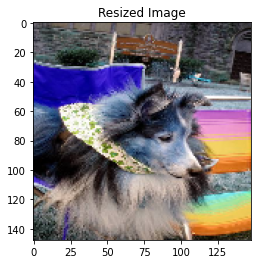

In [ ]:
img_1_resize= cv2.resize(img_1, (148, 148)) 
print (img_1_resize.shape)
plt.title('Resized Image')
plt.imshow(img_1_resize)

Showing some samples:

100%|██████████| 10/10 [00:00<00:00, 36.10it/s]


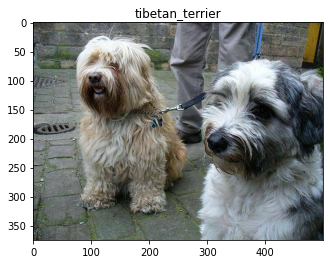

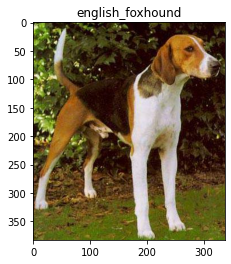

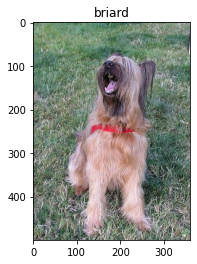

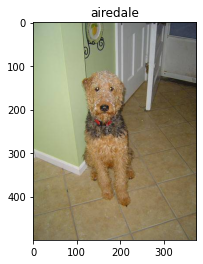

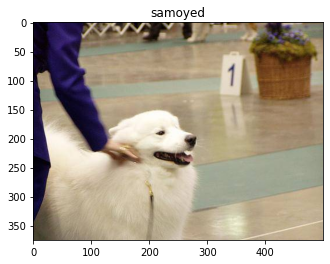

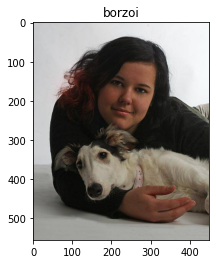

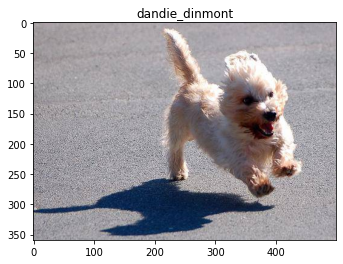

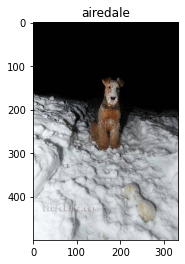

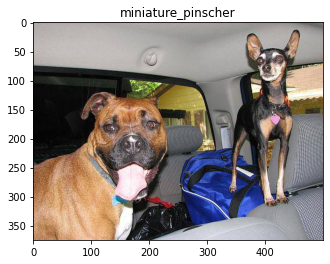

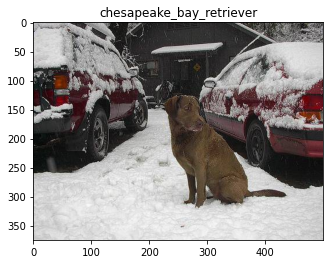

In [ ]:
images=[]
classes=[]
count = 0
for f, breed in tqdm(labeldf.tail(10).values):
    img = cv2.imread(f'/content/sample_data/train/{f}', cv2.COLOR_BGR2RGB)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.title(breed)
    plt.imshow(RGB_img)
plt.show()

We can see the size of the pictures is not unifrom, so we need to resize the images to unified size.


Since we don't have enough data (around 70 images per class)  we can use data augmentation: shifting the image, shearing, zooming and fliping
to get more samples for each class.

## Section 2 - Trainning Convolutional Neural Network

At first, we will use a Convolutional Neural Network.
The CNN architecture will be as follows :

* Convolutional Layer n°1 with 32 filters and image input 256*256
  * Max pooling
  * Relu
* Convolutional Layer n°2 with 64 filters
  * Max pooling
  * Relu
* Convolutional Layer n°3 with 128 filters
  * Max pooling
  * Relu
* Convolutional Layer n°4 with 256 filters
  * Max pooling
  * Relu
* Convolutional Layer n°5 with 512 filters
  * Max pooling
  * Relu
* Flatten Layer
* Fully connected layer with 200 nodes
* Fully Connected Layer with 120 nodes (120 = number of breeds) using softmax activation function

for each convolution layer we add padding='same', padding is added for each image as required to make up for overlaps when the input size and kernel size do not perfectly fit, during our experiments we saw that is helps us to improve the validation accuracy.

we are using Softmax activation which is used for multi-class classification problems, it outputs probability distribution hich sumed up to 1, the predicted class is therefore, the item in the list where confidence score is the highest.
Because we are using softmax activation function the loss function we are going to use, is the categorical cross entropy.

We are going to use optimizer "Adam", During our experiments we saw it perfoms better then RMSprop


In [ ]:
def create_model(image_size):
  model=Sequential()
  model.add(Conv2D(32,input_shape=(image_size,image_size,3),kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(256,kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(512,kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(200, activation='relu'))
  model.add(Dense(120,activation='softmax'))

  model.compile(optimizer='Adam',
            loss='categorical_crossentropy', 
            metrics=['accuracy'])
  return model

In [ ]:
image_size = 256
model = create_model(image_size)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 256)      

In [ ]:
def Model_Name(round):
    return "Model_{}.h5".format(round)

Y = labeldf[['breed']]

We are using 5 fold cross validation to measure model performance and compare different settings

In [ ]:
def run_kfold(n_splits, batch_size, image_size, epoches, Y, train_df , create_model, datagen, save_weights_path, patience=1):
  kfold_model = KFold(n_splits=n_splits)


  validate_datagen=ImageDataGenerator(rescale=1./255)


  VALIDATION_ACCURACY = []
  VALIDAITON_LOSS = []
  histories = []
  main_dir = "/content/sample_data/" 
  round_kfold = 1

  for train_index, val_index in kfold_model.split(np.zeros(len(Y)),Y):
      training_data = train_df.iloc[train_index]
      validation_data = train_df.iloc[val_index]
      
      train_data_generator = datagen.flow_from_dataframe(training_data, directory=os.path.join(main_dir,'train'),
                                  x_col = "id", y_col = "breed",
                                  target_size=(image_size, image_size),
                                  color_mode="rgb", 
                                  batch_size=batch_size,
                                  class_mode = "categorical", shuffle = True)
      valid_data_generator = validate_datagen.flow_from_dataframe(validation_data, directory=os.path.join(main_dir,'train'),
                                x_col = "id", y_col = "breed",
                                  target_size=(image_size, image_size),
                                  color_mode="rgb", 
                                  batch_size=batch_size,
                                class_mode = "categorical", shuffle = True)

    

      checkpoint_accuracy = tf.keras.callbacks.ModelCheckpoint(
                              os.path.join(save_weights_path,Model_Name(round_kfold)), 
                              monitor='val_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')
      checkpoint_earlystoping  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

      callbacks_list = [checkpoint_accuracy, checkpoint_earlystoping]
      
      print("Fold ", round_kfold)

      model = create_model(image_size)
      start_time = timeit.default_timer()
      history = model.fit(train_data_generator,
                  epochs=epoches,
                  callbacks=callbacks_list,
                  steps_per_epoch = len(training_data)//batch_size,
                  validation_steps = len(validation_data)//batch_size,
                  validation_data=valid_data_generator)
      stop_time = timeit.default_timer()
      histories.append(history)

      print("Time fit of this fold: ", stop_time - start_time)
      
      model.load_weights(save_weights_path + Model_Name(round_kfold))
      results = model.evaluate(valid_data_generator)
      results = dict(zip(model.metrics_names,results))
      VALIDATION_ACCURACY.append(results['accuracy'])
      VALIDAITON_LOSS.append(results['loss'])
      tf.keras.backend.clear_session()
      round_kfold += 1

  return histories, model, VALIDATION_ACCURACY, VALIDAITON_LOSS



Prediction function for eavaluating the model

In [ ]:
def prediction(model, name, image_size):
  test_datagen=ImageDataGenerator(rescale=1./255)
  test_generator=test_datagen.flow_from_dataframe(
  dataframe=validatedf,
  directory="/content/sample_data/test",
  x_col="id",
  y_col=None,
  batch_size=1,
  seed=42,
  shuffle=False,
  class_mode=None,
  target_size=(image_size,image_size))

  pred=model.predict_generator(test_generator)
  breeds = np.unique(labeldf['breed'])
  testPath = "/content/sample_data/test"
  np.savetxt("score.csv", pred, delimiter=",")
  testPredictions = np.loadtxt('score.csv', delimiter=',')
  submission = pd.DataFrame(columns=["id"] + list(breeds))
  submission['id'] =[os.path.splitext(path)[0] for path in os.listdir(testPath)]
  submission[list(breeds)] = testPredictions
  submission.to_csv(name+"_results.csv", index=False)
  submission.head()

  return pred

Function for presenting samples of prediction:

In [ ]:
def display_images(model, image_size=256):
  data_images = []
  labels_images = []
  predictions = []
  labels = validatedf.columns
  values = labeldf.tail(40).values
  path = '/content/sample_data/train/'
  for f, breed in tqdm(labeldf.tail(16).values):
      img = load_img(os.path.join(path,f))
      data_images.append(img)
      labels_images.append(breed)
      pred = model.predict(np.expand_dims(np.array(img.resize((image_size,image_size))), axis=0))
      class_num = np.argmax(pred,axis=1)
      prediction = labels[class_num][0]
      predictions.append(prediction)
  nrow =4
  ncol = 4
  y = labels_images
  X = data_images
  skip = 0
  fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=(10,10))
  fig.subplots_adjust(hspace=0.1, wspace=0.1)
  for i in range(nrow*ncol):
      ax[i//ncol,i%ncol].imshow(X[skip+i],cmap='binary')
      ax[i//ncol,i%ncol].set_xticks([])
      ax[i//ncol,i%ncol].set_yticks([])
      if predictions is not None:
          ax[i//ncol,i%ncol].text(0.05, 0.3, str(predictions[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                  color='green' if y[skip+i]==predictions[skip+i] else 'red',weight='bold')
          ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
      else:
          ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
  plt.show()

Function for presenting the validation accuracy and the validation loss of the model:

In [ ]:
def plot_loss_accuracy(validation_accuracy, validation_loss):
  plt.plot(range(0,5), validation_accuracy, 'ro')
  plt.title("Validation Accuracy")
  plt.show()
  names = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

  plt.figure(figsize=(9, 3))

  # plt.bar(names, validation_accuracy)
  plt.title("Validation Loss")
  plt.bar(names, validation_loss)

Function for ploting the training lose vs validation loss and training accuracy vs 
validation accuracy for each fold:

In [ ]:
def plot_acc_vs_loss_metrics(history):
  for i in range(5):
    fig, ax1 = plt.subplots(2)
    ax1[0].plot(history[i].history['loss'], color='b', label="Training loss")
    ax1[0].plot(history[i].history['val_loss'], color='r', label="validation loss",axes =ax1[0])
    legend = ax1[0].legend(loc='best', shadow=True)
    ax1[1].plot(history[i].history['accuracy'], color='b', label="Training accuracy")
    ax1[1].plot(history[i].history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax1[1].legend(loc='best', shadow=True)
    ax1[0].set_title('Fold ' + str(i+1))

### Running the first model:

In [ ]:
save_weights_path = "/content/sample_data/model_1/"
datagen = ImageDataGenerator(rescale=1./255)
history, model, validation_accuracy, validation_loss = run_kfold(5, 64, 256, 10, Y, labeldf, create_model, datagen, save_weights_path, 1)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Fold  1
Epoch 1/10
127/127 [==============================] - ETA: 0s - loss: 4.6520 - accuracy: 0.0287
Epoch 00001: val_accuracy improved from -inf to 0.01008, saving model to /content/sample_data/model_1/Model_1.h5
127/127 [==============================] - 44s 350ms/step - loss: 4.6520 - accuracy: 0.0287 - val_loss: 4.7591 - val_accuracy: 0.0101
Epoch 2/10
127/127 [==============================] - ETA: 0s - loss: 4.1930 - accuracy: 0.0780
Epoch 00002: val_accuracy improved from 0.01008 to 0.02369, saving model to /content/sample_data/model_1/Model_1.h5
127/127 [==============================] - 44s 343ms/step - loss: 4.1930 - accuracy: 0.0780 - val_loss: 4.6685 - val_accuracy: 0.0237
Epoch 3/10
127/127 [==============================] - ETA: 0s - loss: 3.7639 - accuracy: 0.1363
Epoch 00003: val_accuracy improved from 0.02369 to 0.04536, saving model to /cont

Plotting the validation accuracy:

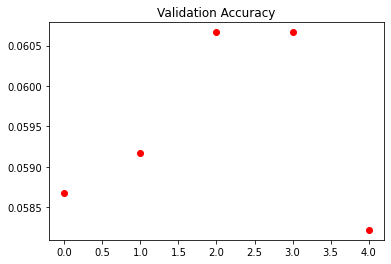

<BarContainer object of 5 artists>

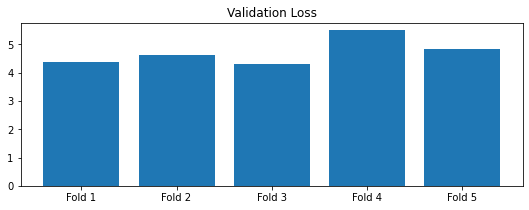

In [ ]:
plot_loss_accuracy(validation_accuracy, validation_loss)

We saw that the best val accuracy and loss accuracy we recived was in fold 3.
Lets see the predict score and the evaluate score:



In [ ]:
save_weights_path = "/content/sample_data/model_1/"
image_size = 256
model = create_model(image_size)
model.load_weights(save_weights_path + "Model_3.h5")
pre_model_1 = prediction(model, "first_model", image_size)

Found 10357 validated image filenames.
Instructions for updating:
Please use Model.predict, which supports generators.


We get **prediction score** of 13.74325 :(

Ploting the training lose vs validation loss and training accuracy vs validation accuracy for each fold:

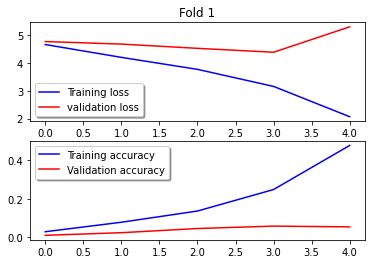

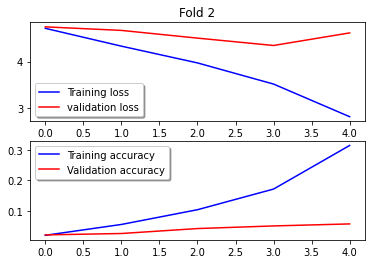

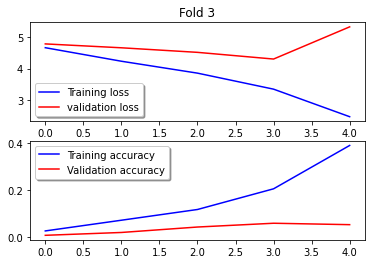

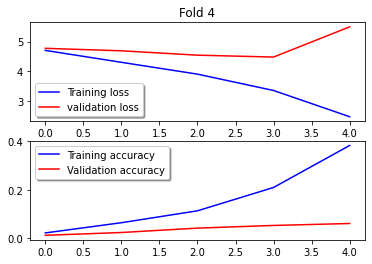

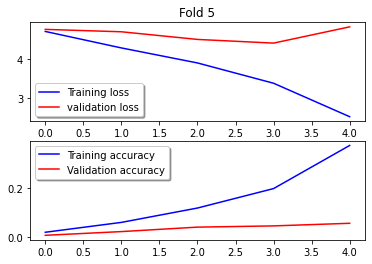

In [ ]:
plot_acc_vs_loss_metrics(history)

Examples of images with there labels (in blue) and the prediction(in red):

100%|██████████| 16/16 [00:00<00:00, 24.25it/s]


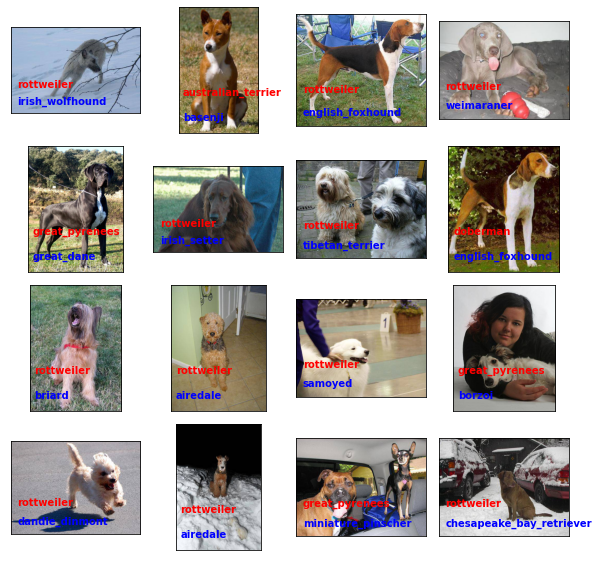

In [ ]:
display_images(model)

We can see the training accuracy is getting very high very quickly, but validation accuracy is staying low. In addition, the validation loss is increasing while the trainning lose is decreasing, that means we have overfitting.
3 ways to improve the results:
1. Simplifying the model - tyring to decrease the number of parameters in the model by removing hidden layers or decreasing the number of neurons in each layer.
2. Add dropout layers -  A dropout layer randomly drops some of the connections between layers. This helps to prevent overfitting, because if a connection is dropped, the network is forced to luckily.
3. Add more data by augmenting the data we already have - This helps in increasing the dataset size and thus reduce overfitting. The reason is that, as we add more data, the model is unable to overfit all the samples, and is forced to generalize.
4. Batch Normalization - is a layer that allows every layer of the network to do learning more independently, it is used to normalize the output of the previous layers. Using batch normalization learning becomes efficient also it can be used as regularization to avoid overfitting of the model.


We are changing the model to reduce the overfitting we are experiencing by (1) adding dropout layers of size 0.3, (2) simplify the model by removing the second dense layer and adding batchNormalization layer beetween every convolution layer.

### Improved model:

* Convolutional Layer n°1 with 32 filters and image input 112*112
  * Max pooling
  * Relu
  * Batch Normalization
* Convolutional Layer n°2 with 64 filters
  * Max pooling
  * Relu
  * Batch Normalization
* Convolutional Layer n°3 with 128 filters
  * Max pooling
  * Relu
  * Batch Normalization
* Convolutional Layer n°4 with 256 filters
  * Max pooling
  * Relu
  * Batch Normalization
* Convolutional Layer n°5 with 512 filters
  * Max pooling
  * Relu
* Flatten Layer
* Dropout
* Fully Connected Layer with 120 nodes (120 = number of breeds) using softmax activation function


In [ ]:
def create_new_model(image_size):
  model=Sequential()
  model.add(Conv2D(32,input_shape=(image_size,image_size,3),kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(256,kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(512,kernel_size=(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(120,activation='softmax'))

  model.compile(optimizer='Adam',
            loss='categorical_crossentropy', 
            metrics=['accuracy'])
  return model

In [ ]:
image_size = 256
model_2 = create_new_model(image_size)
model_2.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)      

Runing the improved model with 5fold cross validation with batch size 32.
Since dropout increases the convergence time we now do 15 epoches per fold (5 more).

In [ ]:
save_weights_path = "/content/sample_data/model_2/"
datagen = ImageDataGenerator(rescale=1./255)
history_2, model_2, validation_accuracy_2, validation_loss_2 = run_kfold(5, 32, 256, 10, Y, labeldf, create_new_model, datagen, save_weights_path, 1)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Fold  1
Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 7.1748 - accuracy: 0.0193
Epoch 00001: val_accuracy improved from -inf to 0.00843, saving model to /content/sample_data/model_2/Model_1.h5
255/255 [==============================] - 46s 180ms/step - loss: 7.1748 - accuracy: 0.0193 - val_loss: 4.8480 - val_accuracy: 0.0084
Epoch 2/10
255/255 [==============================] - ETA: 0s - loss: 4.5070 - accuracy: 0.0435
Epoch 00002: val_accuracy improved from 0.00843 to 0.03224, saving model to /content/sample_data/model_2/Model_1.h5
255/255 [==============================] - 45s 177ms/step - loss: 4.5070 - accuracy: 0.0435 - val_loss: 4.6401 - val_accuracy: 0.0322
Epoch 3/10
255/255 [==============================] - ETA: 0s - loss: 4.2257 - accuracy: 0.0788
Epoch 00003: val_accuracy improved from 0.03224 to 0.04315, saving model to /cont

Plotting validation accuracy and loss accuracy:

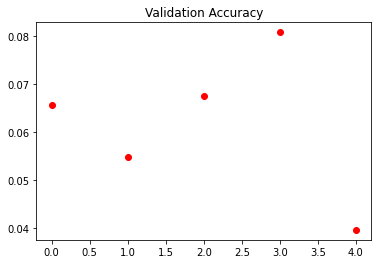

<BarContainer object of 5 artists>

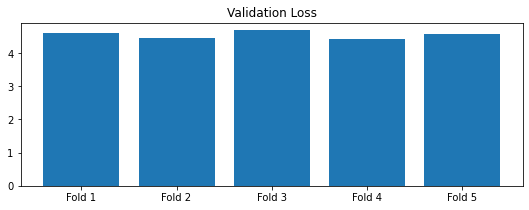

In [ ]:
plot_loss_accuracy(validation_accuracy_2, validation_loss_2)

We can see the validation accuracy is still low but better then the first model we examing. Also the validation loss was a bit better.

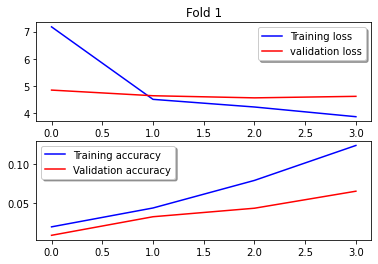

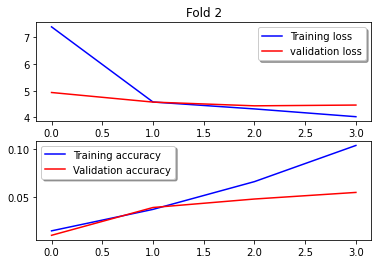

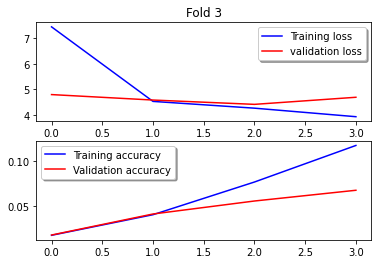

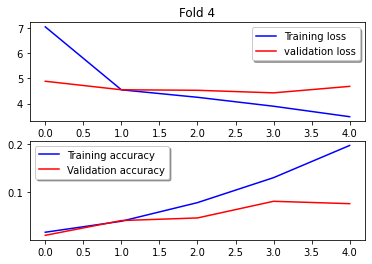

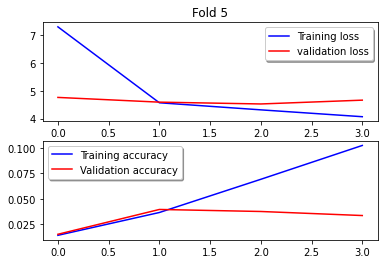

In [ ]:
plot_acc_vs_loss_metrics(history_2)

Conclusion: validation loss is much more steady and smaller then the first model - around 4, the graph shows a moderate increase in the validation accuracy but is still far away from the training accuracy,
in addition, we can see the overfiting significantly reduced.

Prediction score in kaggle submission:

In [ ]:
image_size = 256
model_2.load_weights("/content/sample_data/model_2/Model_4.h5")
prediction(model_2, "model_2", image_size)

Found 10357 validated image filenames.


array([[1.5607620e-05, 3.6486224e-03, 3.3223839e-04, ..., 2.3157832e-03,
        6.6386429e-03, 2.7267095e-03],
       [6.8009031e-06, 2.6613893e-04, 7.1846611e-05, ..., 4.0926076e-05,
        1.2488792e-03, 1.5738261e-03],
       [1.6415021e-03, 1.6565464e-02, 9.6055999e-04, ..., 2.6218148e-03,
        9.9584972e-03, 3.4498135e-03],
       ...,
       [1.3357823e-03, 1.0756033e-02, 8.5023651e-03, ..., 8.1677921e-03,
        1.5677374e-03, 2.3948777e-02],
       [1.8327989e-04, 1.6820528e-02, 1.2436262e-03, ..., 4.0146298e-04,
        1.9046118e-03, 2.0660082e-02],
       [5.7378650e-04, 3.7815172e-02, 9.7026047e-04, ..., 2.3897595e-03,
        1.0339090e-02, 1.0361740e-03]], dtype=float32)

Prediction score in Kaggle: **5.95908**

100%|██████████| 16/16 [00:00<00:00, 24.20it/s]


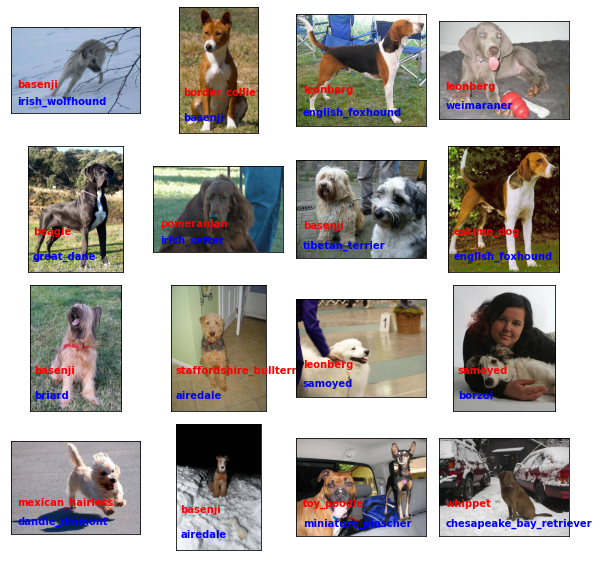

In [ ]:
display_images(model_2)

### Adding augmentation:

Data Augmentation we are going to do:
* rotation range
* width shift
* height shift
* shearing
* zooming
* horizontal flip

Examples:

100%|██████████| 1/1 [00:00<00:00, 174.89it/s]


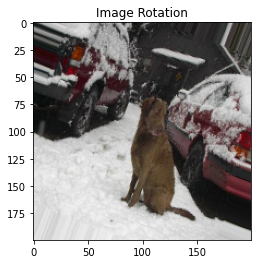

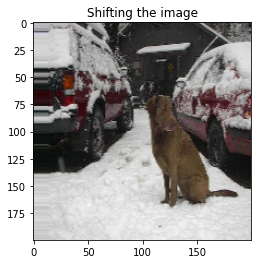

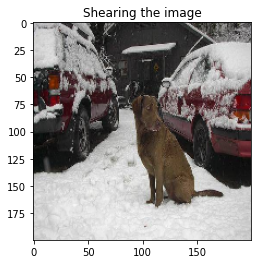

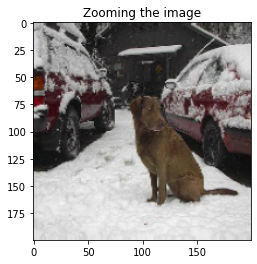

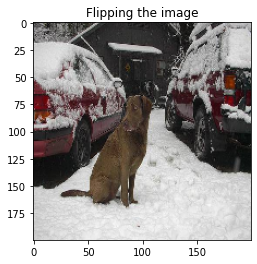

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.preprocessing.image import load_img, img_to_array
from numpy import expand_dims

def plotImage(datagen, title, samples):
	it = datagen.flow(samples, batch_size=1)
	batch = it.next()
	plt.title(title)
	image = batch[0].astype('uint8')
	plt.imshow(image)
	plt.show()
 

for f, breed in tqdm(labeldf.tail(1).values):
    img = cv2.imread(f'/content/sample_data/train/{f}', cv2.COLOR_BGR2RGB)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGB_img = cv2.resize(RGB_img, (200, 200)) 

data = img_to_array(RGB_img)
samples = expand_dims(data, 0)

#Rotation
datagen = ImageDataGenerator(rotation_range=40)
plotImage(datagen, "Image Rotation", samples)

#Shifting
datagen = ImageDataGenerator(width_shift_range=0.2)
plotImage(datagen, "Shifting the image", samples)

# Shearing
datagen = ImageDataGenerator(shear_range=0.5)
plotImage(datagen, "Shearing the image", samples)

# Zooming
datagen = ImageDataGenerator(zoom_range=0.2)
plotImage(datagen, "Zooming the image", samples)

# Flipping
datagen = ImageDataGenerator(horizontal_flip=True)
plotImage(datagen, "Flipping the image", samples)

Because the learning now is very slow (convergence time increased) we will run 35 epoches per fold. We decided to use batch size 32 because during our experiments we saw that batch size 32 is faster in training time and improving the val accuracy.
In addition we saw the validation loss is very jumpy so we are giving the early stopping checkpoint a patience size 10.

In [ ]:
save_weights_path = "/content/sample_data/model_3/"
datagen = ImageDataGenerator(rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
history_aug, model_aug, validation_acc_aug, validation_loss_aug = run_kfold(5, 32, 148, 35, Y, labeldf, create_new_model, datagen, save_weights_path, 10)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Fold  1
Epoch 1/35
255/255 [==============================] - ETA: 0s - loss: 6.1735 - accuracy: 0.0142
Epoch 00001: val_accuracy improved from -inf to 0.00843, saving model to /content/sample_data/model_3/Model_1.h5
255/255 [==============================] - 75s 293ms/step - loss: 6.1735 - accuracy: 0.0142 - val_loss: 5.0877 - val_accuracy: 0.0084
Epoch 2/35
255/255 [==============================] - ETA: 0s - loss: 4.6370 - accuracy: 0.0298
Epoch 00002: val_accuracy improved from 0.00843 to 0.03075, saving model to /content/sample_data/model_3/Model_1.h5
255/255 [==============================] - 75s 295ms/step - loss: 4.6370 - accuracy: 0.0298 - val_loss: 4.6097 - val_accuracy: 0.0308
Epoch 3/35
255/255 [==============================] - ETA: 0s - loss: 4.4898 - accuracy: 0.0403
Epoch 00003: val_accuracy did not improve from 0.03075
255/255 [=================

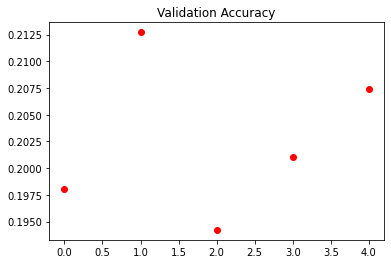

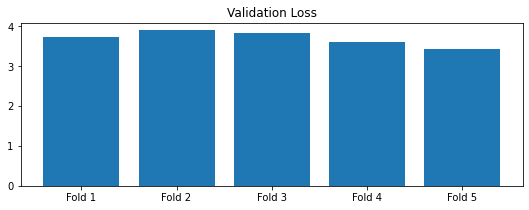

In [ ]:
plot_loss_accuracy(validation_acc_aug, validation_loss_aug)

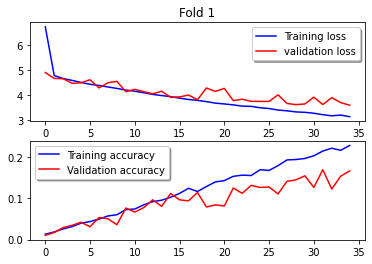

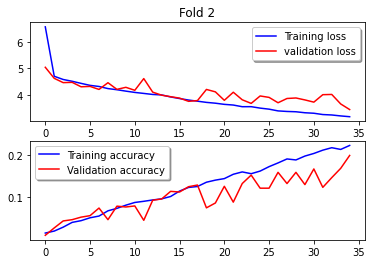

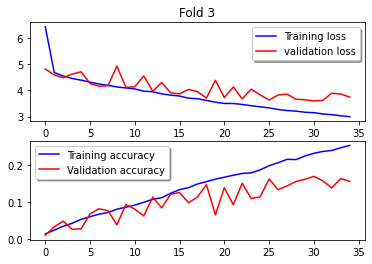

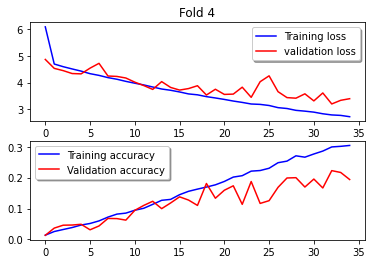

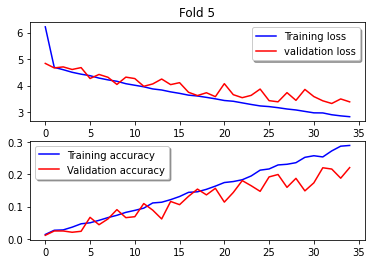

In [ ]:
plot_acc_vs_loss_metrics(history_aug)

Prediction score in kaggle:

In [ ]:
image_size = 148
model_aug.load_weights("/content/sample_data/model_3/Model_4.h5")
prediction(model_aug, "aug_model", image_size)

Found 10357 validated image filenames.
Instructions for updating:
Please use Model.predict, which supports generators.


array([[2.1010181e-05, 1.3704288e-02, 7.6573720e-05, ..., 2.8946518e-03,
        1.7643201e-01, 7.1573285e-03],
       [6.7456617e-06, 1.9506062e-05, 4.2867773e-06, ..., 1.0905900e-03,
        1.0227348e-02, 1.5185875e-04],
       [5.5575636e-03, 5.4791979e-03, 3.3455670e-03, ..., 1.6250661e-02,
        9.5350696e-03, 3.0151245e-03],
       ...,
       [4.0308955e-06, 6.6218490e-04, 6.9167436e-05, ..., 3.4724858e-03,
        8.3093001e-03, 3.5034574e-04],
       [1.0878480e-03, 4.1203494e-03, 6.5620581e-04, ..., 1.3965233e-03,
        1.7455552e-02, 1.6502095e-02],
       [1.2986551e-03, 3.5168990e-02, 5.4487813e-04, ..., 1.0600746e-02,
        1.7503170e-02, 1.5715990e-03]], dtype=float32)

Prediction score: **8.16839**

100%|██████████| 16/16 [00:00<00:00, 27.24it/s]


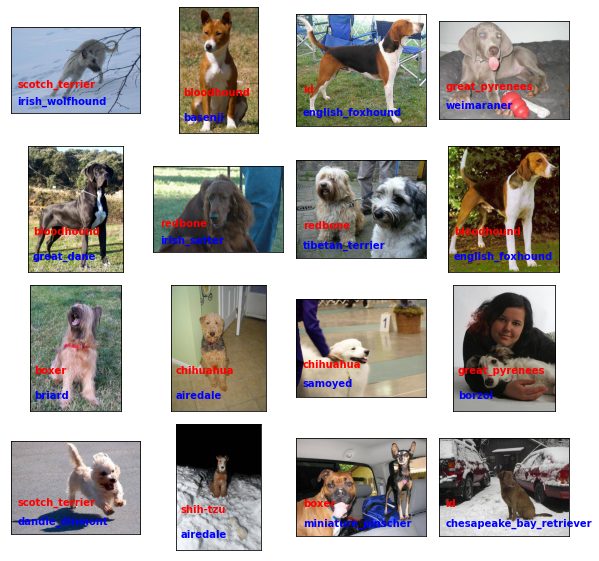

In [ ]:
display_images(model_aug, image_size)

### **Summary**:

<BarContainer object of 3 artists>

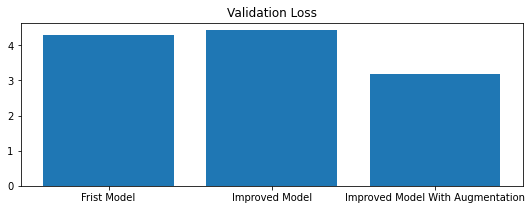

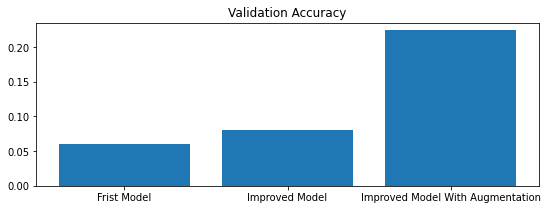

In [ ]:
total_validation_accuracy = []
total_validation_loss = []
total_validation_accuracy.append(validation_accuracy[2])
total_validation_accuracy.append(validation_accuracy_2[3])
total_validation_accuracy.append(validation_accuracy_aug[0])
total_validation_loss.append(validation_loss[2])
total_validation_loss.append(validation_loss_2[3])
total_validation_loss.append(validation_loss_aug[0])
names = ['First Model', 'Improved Model', 'Improved Model With Augmentation']

plt.figure(figsize=(9, 3))
plt.title("Validation Loss")
plt.bar(names, total_validation_loss)
plt.figure(figsize=(9, 3))
plt.title("Validation Accuracy")
plt.bar(names, total_validation_accuracy)

We can clearly see there is improvements in the improved models,
the biggest improvements are with data augmentation, which gets validation accuracy of more then 20% and validation loss of 3.

**Other changes we could add that might have helped:**
1. Add more epochs
2. Add more dropouts layers.
3. Increasing the dorpout.

## Section 3 - Training using pretraind model

In [ ]:
import os
import pandas as pd
import numpy as np
import zipfile
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.optimizers import Adam

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import timeit

### Functions


Genrating Inception V3, with MaxPooling,Droput and Dense layer

In [ ]:

def Get_InceptionV3():

  tf.keras.backend.clear_session()
  model_base = InceptionV3(weights='imagenet',pooling='max',include_top=False,input_shape=(299,299,3))
  for i in model_base.layers:
      i.trainable = False
  model = Sequential()
  model.add(model_base)
  model.add(Dropout(0.5))
  model.add(Dense(120))
  model.add(Activation('softmax'))
  adam =Adam(lr=0.0001)
  model.compile(optimizer=adam,loss="categorical_crossentropy",metrics=['accuracy'])
  return model

Genrating Xception V3, with MaxPooling,Droput and Dense layer

In [ ]:

def Get_Xception():

  tf.keras.backend.clear_session()
  model_base = Xception(weights='imagenet',pooling='max',include_top=False,input_shape=(299,299,3))
  for i in model_base.layers:
      i.trainable = False
  model = Sequential()
  model.add(model_base)
  model.add(Dropout(0.5))
  model.add(Dense(120))
  model.add(Activation('softmax'))
  adam =Adam(lr=0.0001)
  model.compile(optimizer=adam,loss="categorical_crossentropy",metrics=['accuracy'])
  return model

Ploting History of a model

In [ ]:
def Plot_History(history):
  fig, ax = plt.subplots(1,2,figsize=(12,4))
  ax[0].plot(history.history['loss'], color='b', label="Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
  ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
  legend = ax[1].legend(loc='best', shadow=True)

  plt.show()

### Data Prepare


In [ ]:
train_zip_path = '/content/sample_data/train.zip'
test_zip_path = '/content/sample_data/test.zip'
sample_submission_zip_path = '/content/sample_data/sample_submission.csv.zip'
zip_ref = zipfile.ZipFile(train_zip_path, 'r')
zip_ref.extractall('/content/sample_data/train')
zip_ref = zipfile.ZipFile(test_zip_path, 'r')
zip_ref.extractall('/content/sample_data/test')
zip_ref.close()

In [ ]:

labeldf= pd.read_csv('/content/sample_data/labels.csv',dtype=str)
main_dir ='/content/sample_data/'
save_dir = "/content/sample_data/"
train_df = labeldf[['breed']]
train_df['id'] = labeldf['id'] + '.jpg'
train_df.count()

breed    10222
id       10222
dtype: int64

We choose to use early stop monitored by val_loss, in order to avoid overfitting. we found that for this data patience of 2 worked us the best.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('/content/sample_data/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
cb_list = [es, mc]  

In [ ]:
num = train_df['id'].count()
index = int(num*0.8)
train_set = train_df[:index]
valid_set =train_df[index:]

In [ ]:
train_set['id'].count()

8177

ImageDataGenerator init, sperating the genrator to train and valid

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size=32

train_data_generator = datagen.flow_from_dataframe(train_set, directory=os.path.join(main_dir,'train'),
                            x_col = "id", y_col = "breed",
                            target_size=(299, 299),
                            color_mode="rgb", 
                            batch_size=batch_size,
                            class_mode = "categorical", shuffle = True)
valid_data_generator = datagen.flow_from_dataframe(valid_set, directory=os.path.join(main_dir,'train'),
                          x_col = "id", y_col = "breed",
                            target_size=(299, 299),
                            color_mode="rgb", 
                            batch_size=batch_size,
                          class_mode = "categorical", shuffle = True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
                        os.path.join(save_dir,"output"), 
                        monitor='val_accuracy', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='max')

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


###Models

####InceptionV3


In [ ]:
# instantiating the InceptionV3 model in the strategy scope creates the model on the TPU
model = Get_InceptionV3()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
_________________________________________________________________
activation_94 (Activation)   (None, 120)               0         
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# # There can be other callbacks, but just showing one because it involves the model name
# # This saves the best model
# # FIT THE MODEL
start=timeit.default_timer()
history = model.fit(train_data_generator,
            epochs=20,
            callbacks=cb_list,
            steps_per_epoch = train_set['id'].count()//batch_size+1,
            validation_steps = valid_set['id'].count()//batch_size+1,
            validation_data = valid_data_generator)
end = timeit.default_timer()
time_train_inepctionv3=end-start


Epoch 1/20
256/256 [==============================] - 56s 217ms/step - loss: 8.1534 - accuracy: 0.0498 - val_loss: 2.5072 - val_accuracy: 0.3922
Epoch 2/20
256/256 [==============================] - 54s 213ms/step - loss: 4.3650 - accuracy: 0.2518 - val_loss: 1.0401 - val_accuracy: 0.7222
Epoch 3/20
256/256 [==============================] - 55s 214ms/step - loss: 2.7187 - accuracy: 0.4499 - val_loss: 0.6788 - val_accuracy: 0.8122
Epoch 4/20
256/256 [==============================] - 55s 214ms/step - loss: 1.9276 - accuracy: 0.5841 - val_loss: 0.5573 - val_accuracy: 0.8396
Epoch 5/20
256/256 [==============================] - 55s 215ms/step - loss: 1.6042 - accuracy: 0.6489 - val_loss: 0.5366 - val_accuracy: 0.8450
Epoch 6/20
256/256 [==============================] - 55s 214ms/step - loss: 1.3366 - accuracy: 0.6979 - val_loss: 0.5005 - val_accuracy: 0.8518
Epoch 7/20
256/256 [==============================] - 55s 214ms/step - loss: 1.2049 - accuracy: 0.7301 - val_loss: 0.4700 - val_ac

As you can see we stopes at the 10 epoch where we stoped by the call back, seeing that we didnt overfit the model.

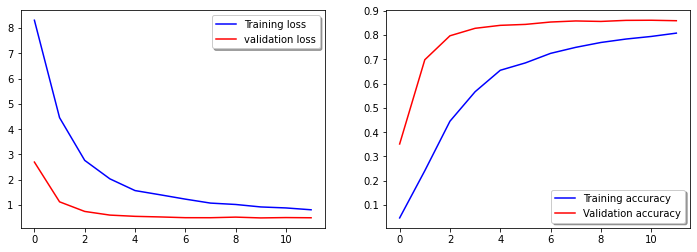

In [ ]:
Plot_History(history)

##### Inception V3 as feature extractor



In [ ]:
model.summary()
sliced_loaded_model = Sequential(model.layers[:-2])
sliced_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
_________________________________________________________________
activation_94 (Activation)   (None, 120)               0         
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
________________

In [ ]:

start = timeit.default_timer()
train_features = sliced_loaded_model.predict_generator(train_data_generator,steps = train_set['id'].count()//batch_size+1,verbose=0)
valid_features = sliced_loaded_model.predict_generator(valid_data_generator,steps = valid_set['id'].count()//batch_size+1,verbose=0)
end = timeit.default_timer()
feature_extract_inceptionV3=end-start



In [ ]:
start=timeit.default_timer()
lrc = LogisticRegression(n_jobs=8,solver='lbfgs',multi_class='auto')
lrc.fit(train_features,train_data_generator.labels)
end = timeit.default_timer()
time_train_logistic_iceptionv3=end-start

start=timeit.default_timer()
preds_lrc = lrc.predict(valid_features)
lrc_acc= metrics.accuracy_score(preds_lrc, valid_data_generator.labels)
print(lrc_acc)
end = timeit.default_timer()
time_predict_logistic_iceptionv3=end-start

0.009779951100244499


In [ ]:
start=timeit.default_timer()
svm = SVC(max_iter=100,gamma='auto')
svm.fit(train_features,train_data_generator.labels)
end = timeit.default_timer()
time_train_svm_iceptionv3=end-start

start=timeit.default_timer()
pred_svm = svm.predict(valid_features)
svm_acc = metrics.accuracy_score(pred_svm,valid_data_generator.labels)
print(svm_acc)
end = timeit.default_timer()
time_predict_svm_iceptionv3=end-start


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.0117359413202934


####Xepction

In [ ]:
model = Get_Xception()
model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
_________________________________________________________________
activation (Activation)      (None, 120)               0         
Total params: 21,107,360
Trainable params: 245,880
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
# # There can be other callbacks, but just showing one because it involves the model name
# # This saves the best model
# # FIT THE MODEL
start=timeit.default_timer()
history = model.fit(train_data_generator,
            epochs=20,
            callbacks=cb_list,
            steps_per_epoch = train_set['id'].count()//batch_size+1,
            validation_steps = valid_set['id'].count()//batch_size+1,
            validation_data = valid_data_generator)
end = timeit.default_timer()
time_train_xepction=end-start


Epoch 1/20
256/256 [==============================] - 77s 300ms/step - loss: 4.4097 - accuracy: 0.1634 - val_loss: 1.3505 - val_accuracy: 0.6836
Epoch 2/20
256/256 [==============================] - 79s 307ms/step - loss: 1.6255 - accuracy: 0.5624 - val_loss: 0.6274 - val_accuracy: 0.8249
Epoch 3/20
256/256 [==============================] - 81s 317ms/step - loss: 1.0132 - accuracy: 0.7094 - val_loss: 0.4774 - val_accuracy: 0.8548
Epoch 4/20
256/256 [==============================] - 83s 324ms/step - loss: 0.7759 - accuracy: 0.7709 - val_loss: 0.4329 - val_accuracy: 0.8675
Epoch 5/20
256/256 [==============================] - 84s 329ms/step - loss: 0.6567 - accuracy: 0.7989 - val_loss: 0.4044 - val_accuracy: 0.8748
Epoch 6/20
256/256 [==============================] - 84s 330ms/step - loss: 0.6024 - accuracy: 0.8168 - val_loss: 0.3855 - val_accuracy: 0.8778
Epoch 7/20
256/256 [==============================] - 84s 330ms/step - loss: 0.5291 - accuracy: 0.8355 - val_loss: 0.3808 - val_ac

As you can see we stopes at the 11 epoch where we stoped by the call back, seeing that we didnt overfit the model.

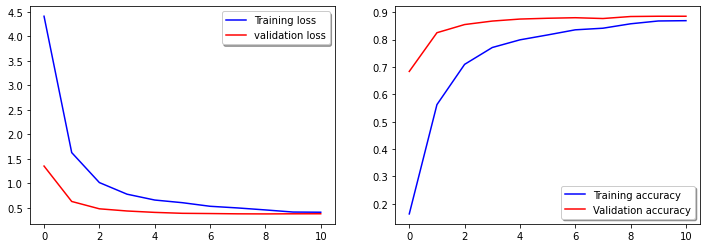

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

##### Xeption as feature extractor

In [ ]:

# You can take the output of the last model and create a new model. The lower layers remains the same.
model.load_weights('/content/sample_data/best_model.h5')
model.summary()
sliced_loaded_model = Sequential(model.layers[:-2])
sliced_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
_________________________________________________________________
activation (Activation)      (None, 120)               0         
Total params: 21,107,360
Trainable params: 245,880
Non-trainable params: 20,861,480
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
________________

In [ ]:
train_features = sliced_loaded_model.predict_generator(train_data_generator,steps = train_set['id'].count()//batch_size+1,verbose=0)
valid_features = sliced_loaded_model.predict_generator(valid_data_generator,steps = valid_set['id'].count()//batch_size+1,verbose=0)


64/64 [==============================] - 17s 258ms/step


Running LRC model

In [ ]:
start=timeit.default_timer()
lrc = LogisticRegression(n_jobs=8,solver='lbfgs',multi_class='auto')
lrc.fit(train_features,train_data_generator.labels)
end = timeit.default_timer()
time_train_logistic_xepction=end-start


start=timeit.default_timer()
preds_lrc = lrc.predict(valid_features)
lrc_acc= metrics.accuracy_score(preds_lrc, valid_data_generator.labels)
print(lrc_acc)
end = timeit.default_timer()
time_predict_logistic_xepction=end-start


0.010268948655256724


Running SVM model

In [ ]:
stds = StandardScaler()
svm = SVC(max_iter=100,gamma='auto')
start=timeit.default_timer()
svm.fit(stds.fit_transform(train_features),train_data_generator.labels)
end = timeit.default_timer()
time_train_svm_xepction=end-start

start=timeit.default_timer()
pred_svm = svm.predict(valid_features)
svm_acc = metrics.accuracy_score(pred_svm,valid_data_generator.labels)
print(svm_acc)
end = timeit.default_timer()
time_predict_svm_xepction=end-start


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.01613691931540342


###Experiments Summary

Comparation beetwen 2 diffrent trained model architecture.
We choose to check each model as feature extractor and checked how it worked with diffrent classic ML models (SVM and Logistic Reggrision).

In [ ]:
input_shape = "(299,299,3)"
svm_imput_shape = "(1,2048)"
lrc_imput_shape = "(1,2048)"

summary = pd.DataFrame(columns=[ '' ,])
summary[''] = ['Train Time' ,'Val Acc','Val Loss']
summary.set_index('', inplace=True)

summary.loc['Train Time' , 'IceptionV3'] = time_train_inepctionv3
summary.loc['Val Acc' , 'IceptionV3'] = 0.8592
summary.loc['Val Loss' , 'IceptionV3'] = 0.4911

summary.loc['Train Time' , 'Xception'] = time_train_xepction
summary.loc['Val Acc' , 'Xception'] = 0.8851
summary.loc['Val Loss' , 'Xception'] = 0.3764

summary.loc['Train Time' , 'IceptionV3_LRC'] = time_train_logistic_iceptionv3
summary.loc['Val Acc' , 'IceptionV3_LRC'] = 0.010

summary.loc['Train Time' , 'Xception_LRC'] = time_train_logistic_xepction
summary.loc['Val Acc' , 'Xception_LRC'] = 0.010

summary.loc['Train Time' , 'IceptionV3_SVM'] = time_train_svm_iceptionv3
summary.loc['Val Acc' , 'IceptionV3_SVM'] = 0.009

summary.loc['Train Time' , 'Xception_SVM'] = time_train_svm_xepction
summary.loc['Val Acc' , 'Xception_SVM'] = 0.016

summary




IceptionV3    Xception  ...  IceptionV3_SVM  Xception_SVM
                                    ...                              
Train Time  554.509355  666.841149  ...      388.631781     372.84465
Val Acc       0.859200    0.885100  ...        0.009000       0.01600
Val Loss      0.491100    0.376400  ...             NaN           NaN

[3 rows x 6 columns]

As you can see we got high accuracy and low val loss on InceptionV3 and Xception, but unfortunately using the classic ML algorithms with feature extraction didnt work very well.

# Conclusion

The goal of the project is to let us gain experience in implementing a simple CNN Model, and then try a bit more complicated models, in order to see the influence they have on the prediction performance.

In the first part we analysed data in order to understand the kind of data we are going to work with. We realized the size of the dataset is very big, but since there are many classifications (120), each classification had a small number of pictures. Because of that, we knew beforehand we won’t be able to get a very good performance, at least in the simple models. In addition, the pictures came in different sizes, so we modified the pictures in order to have a uniform size for all the pictures – which can lead to data loss, for better or for worse. 

In the second part we built a simple CNN Model with number of convolutions and one more inner neuron layer. We saw the model converges relatively fast and we could easily identify that we have reached an overfitting. We then made some experiments in order to understand how to overcome this problem, and we realized this can be done mainly by simplifying the model to a model without inner neuron layer and with dropout, which will make it harder to the model to get fixed. By simplifying the model we could see there was an improvement but not enough to get good results.

Afterwards we ran the improved model with addition of Data Augmentation – which reduced  the convergence rate. Due to lack of time, we couldn’t run the model on a large amount of epochs, but even with the amount we ran we could notice significant improvement in the results. 

During the work, we have learned a lot about how slight changes in the model’s parameters can lead to different results, and the model can constantly be improved if you only have the time and resources for that.

In the third part of the summary we practiced pre trained models, using the weights of ‘ImageNet’.
At the beginning we didn’t really understand the whole idea behind pretrained weights and “wasted” time and mostly GPU time, until we understood the power of those pretrained weights models. We choose to work with InceptionV3 and Xception model architecture together with a classifier dense layer, where we were very surprises to see how a model can converge way faster and give much better performance on  loss value and validation accuracy metrics, comparing to the models we used on part 2.

Then we practiced each of the architecture as a feature extractor, by omitting the dense layer and adding a pooling layer at the end of each architecture, in order to reduce the tensor into one dimensional array of 2048, where each index represent different feature. 
After extracting the train data set feature by using predict we got a data set of feature arrays instead of 3-dimensional JPG file, using the feature data as a training set for our classic ML algorithms SVM and Logistic regression. 

We faced many technical problems with our RAM capacity using the Google Collab platform until we succeed to run this part of the assignment.
 Finally after a long battle we it we succeeded to get nice Val loss accuracy and Validation accuracy (0.9) on both architectures on 3c, but unfortunately we didn’t succeed on the Classic ML algorithms 3d like we hoped for. 

To summarize we had a lot of fun (and even more pain) doing this assignment learning a lot about Convolutional neural network, using new technologies and platforms we didn’t used before and the most important how to create a classifier for the dog next will adopt.
 